## Loading Packages

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import tensorflow as tf

# Keras modules
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, Input, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Sklearn metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix


## Data Loading

In [2]:
!unzip 'asl_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: asl_dataset/asl_dataset/r/hand2_r_left_seg_4_cropped.jpeg  
  inflating: __MACOSX/asl_dataset/asl_dataset/r/._hand2_r_left_seg_4_cropped.jpeg  
  inflating: asl_dataset/asl_dataset/r/hand5_r_dif_seg_3_cropped.jpeg  
  inflating: __MACOSX/asl_dataset/asl_dataset/r/._hand5_r_dif_seg_3_cropped.jpeg  
  inflating: asl_dataset/asl_dataset/r/hand2_r_left_seg_3_cropped.jpeg  
  inflating: __MACOSX/asl_dataset/asl_dataset/r/._hand2_r_left_seg_3_cropped.jpeg  
  inflating: asl_dataset/asl_dataset/r/hand1_r_dif_seg_4_cropped.jpeg  
  inflating: __MACOSX/asl_dataset/asl_dataset/r/._hand1_r_dif_seg_4_cropped.jpeg  
  inflating: asl_dataset/asl_dataset/r/hand4_r_bot_seg_1_cropped.jpeg  
  inflating: __MACOSX/asl_dataset/asl_dataset/r/._hand4_r_bot_seg_1_cropped.jpeg  
  inflating: asl_dataset/asl_dataset/r/hand1_r_dif_seg_3_cropped.jpeg  
  inflating: __MACOSX/asl_dataset/asl_dataset/r/._hand1_r_dif_seg_3_cropped.jpeg  
  inflating: as

## Data Preparation

In [3]:
import pandas as pd
import re
# Base path for the dataset
base_path = "asl_dataset/asl_dataset/"

# Dictionary to save our 36 classes
categories = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "a", 11: "b", 12: "c", 13: "d", 14: "e", 15: "f", 16: "g", 17: "h", 18: "i",
    19: "j", 20: "k", 21: "l", 22: "m", 23: "n", 24: "o", 25: "p", 26: "q", 27: "r",
    28: "s", 29: "t", 30: "u", 31: "v", 32: "w", 33: "x", 34: "y", 35: "z",
}

def add_class_name_prefix(df, col_name):
    def modify_filename(filename):
        match = re.search("_", filename)
        if match:
            return filename[match.start() + 1: match.start() + 2] + "/" + filename
        return filename  # Return the original filename if no "_" is found

    df[col_name] = df[col_name].apply(modify_filename)
    return df

# List containing all the filenames in the dataset
filenames_list = []
# List to store the corresponding categories
categories_list = []

for category in categories:
    category_path = os.path.join(base_path, categories[category])
    if os.path.exists(category_path):  # Check if the category path exists
        filenames = os.listdir(category_path)
        filenames_list.extend(filenames)
        categories_list.extend([category] * len(filenames))

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})

df = add_class_name_prefix(df, "filename")

df = df.sample(frac=1).reset_index(drop=True)


In [4]:
# Extra file being made
df = df[df['filename'] != "S/.DS_Store"]

In [5]:
print("number of elements = ", len(df))

number of elements =  2515


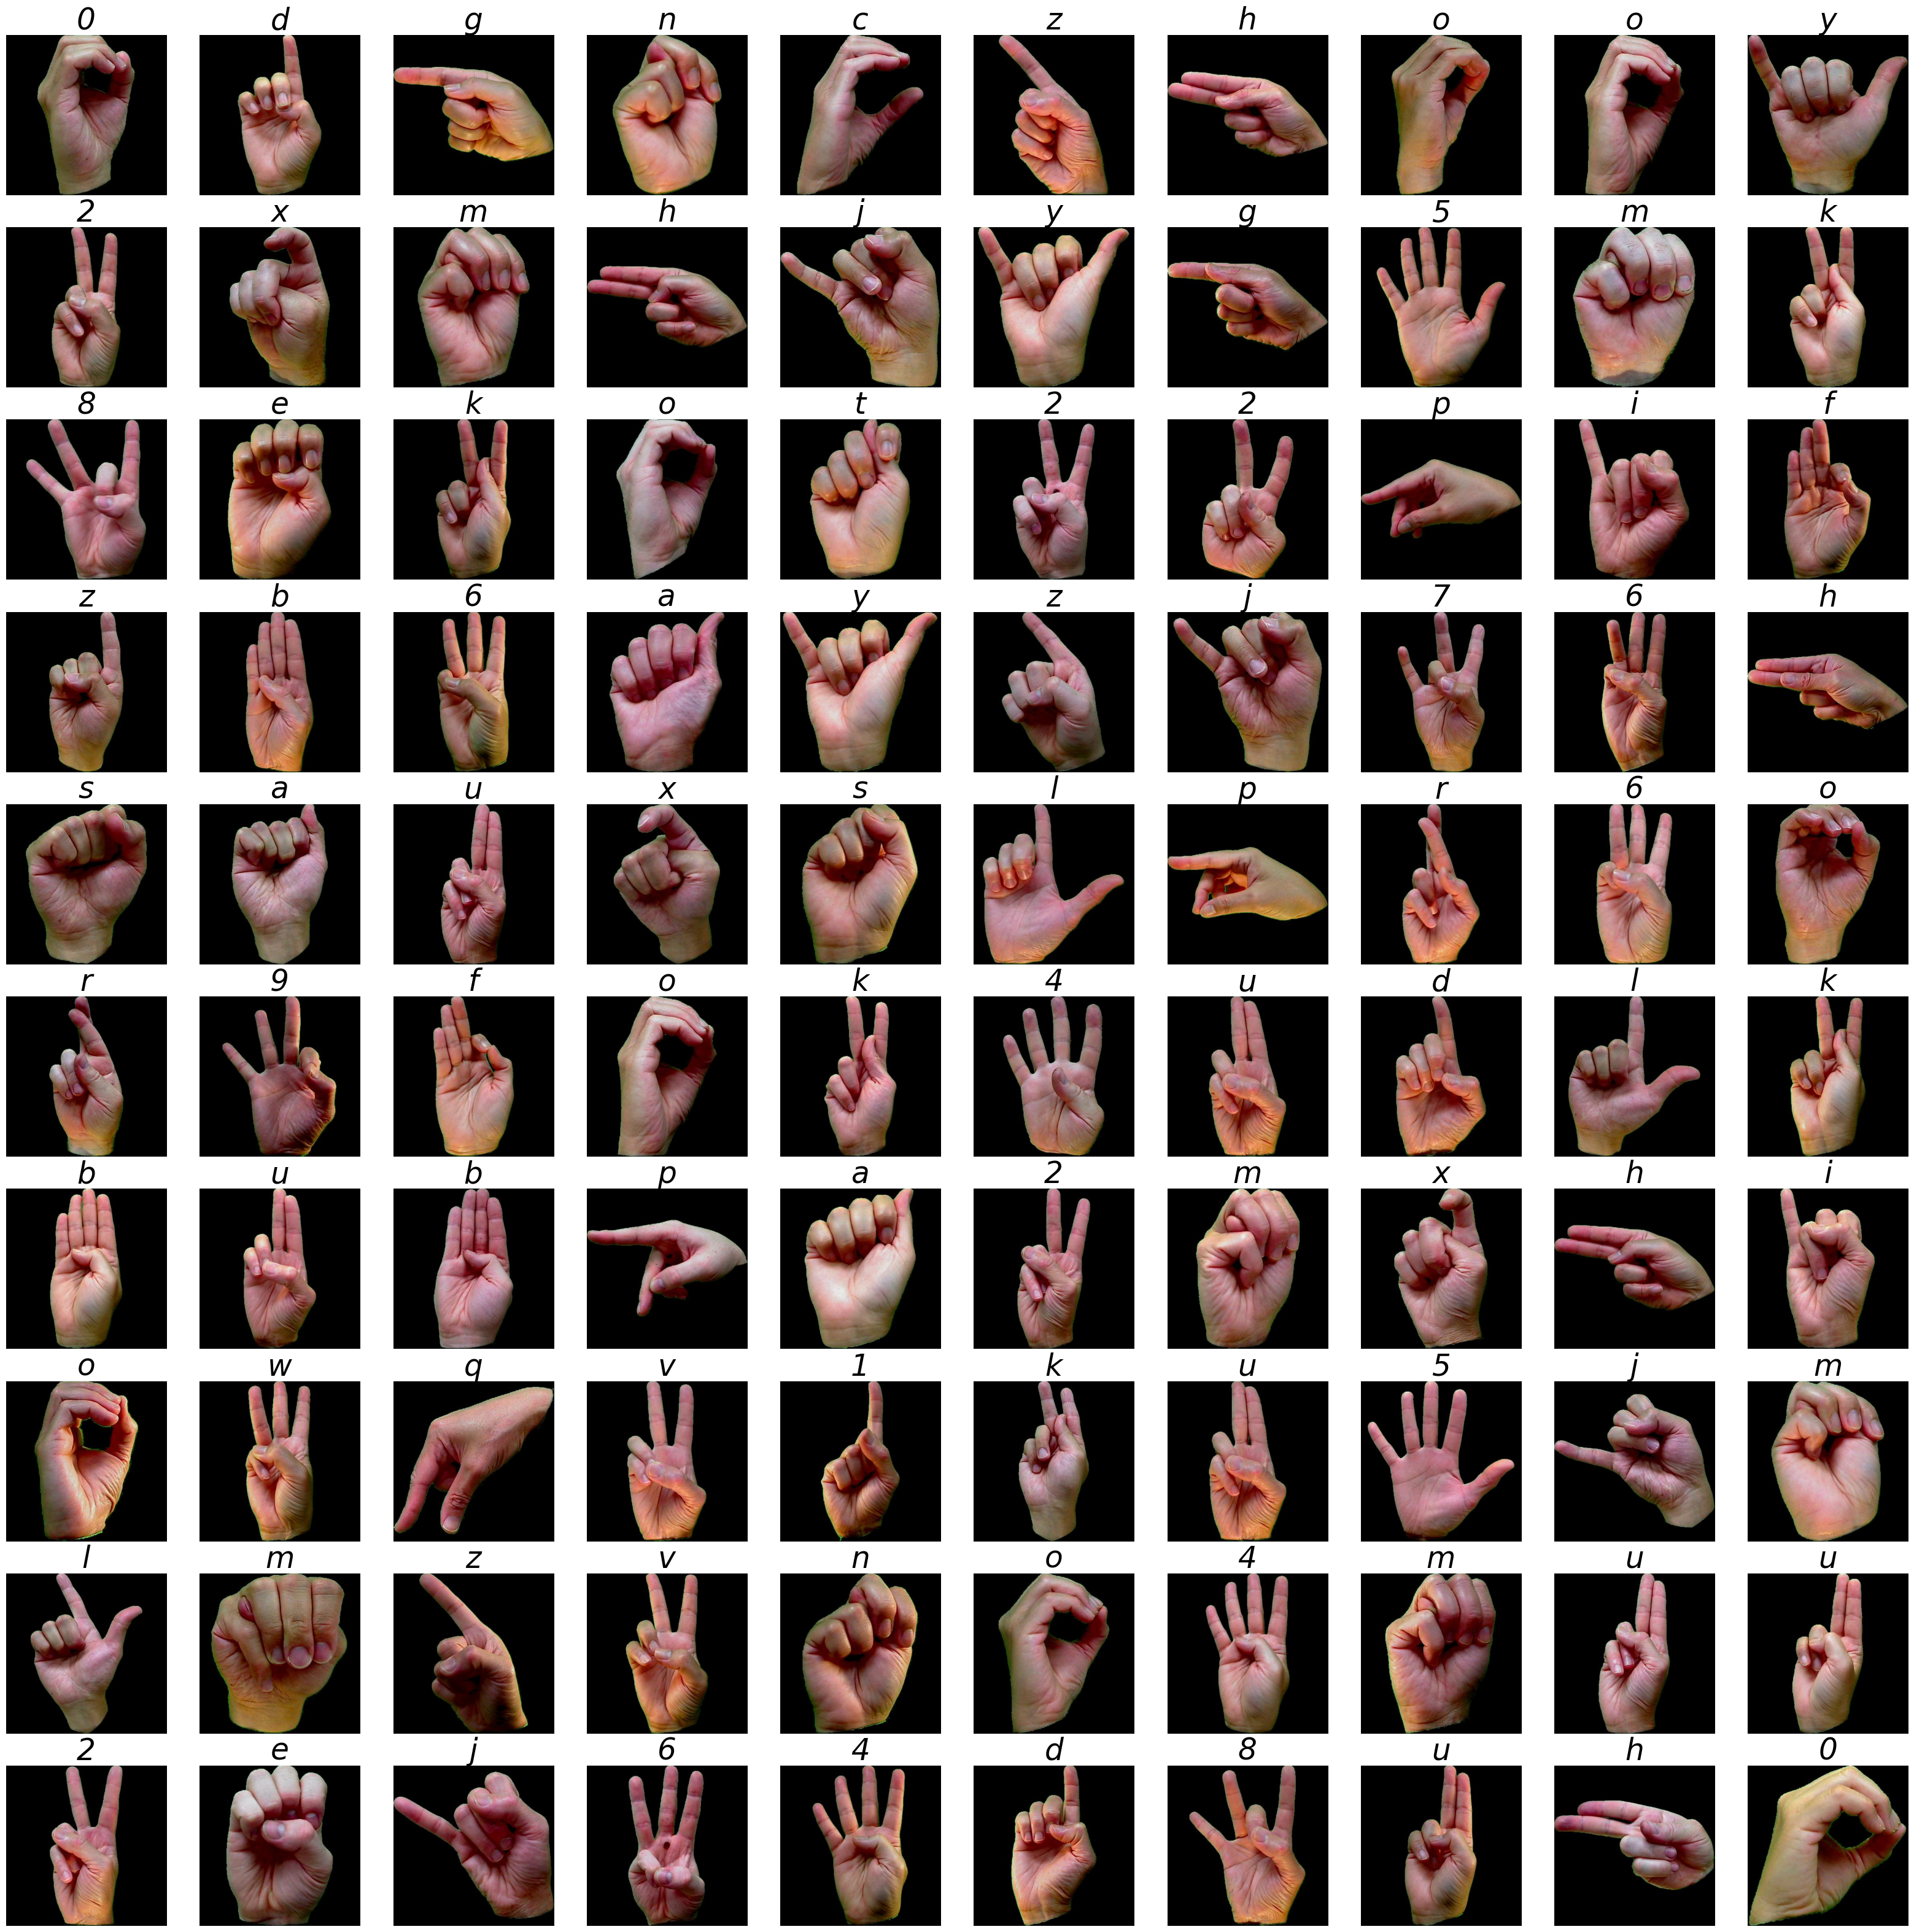

In [6]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = base_path + df.filename[i]
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35,fontstyle='italic')
    plt.axis("off")

<ipython-input-7-02c7bf936d96>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni, x='Category', y='Count', palette='icefire').set_title(


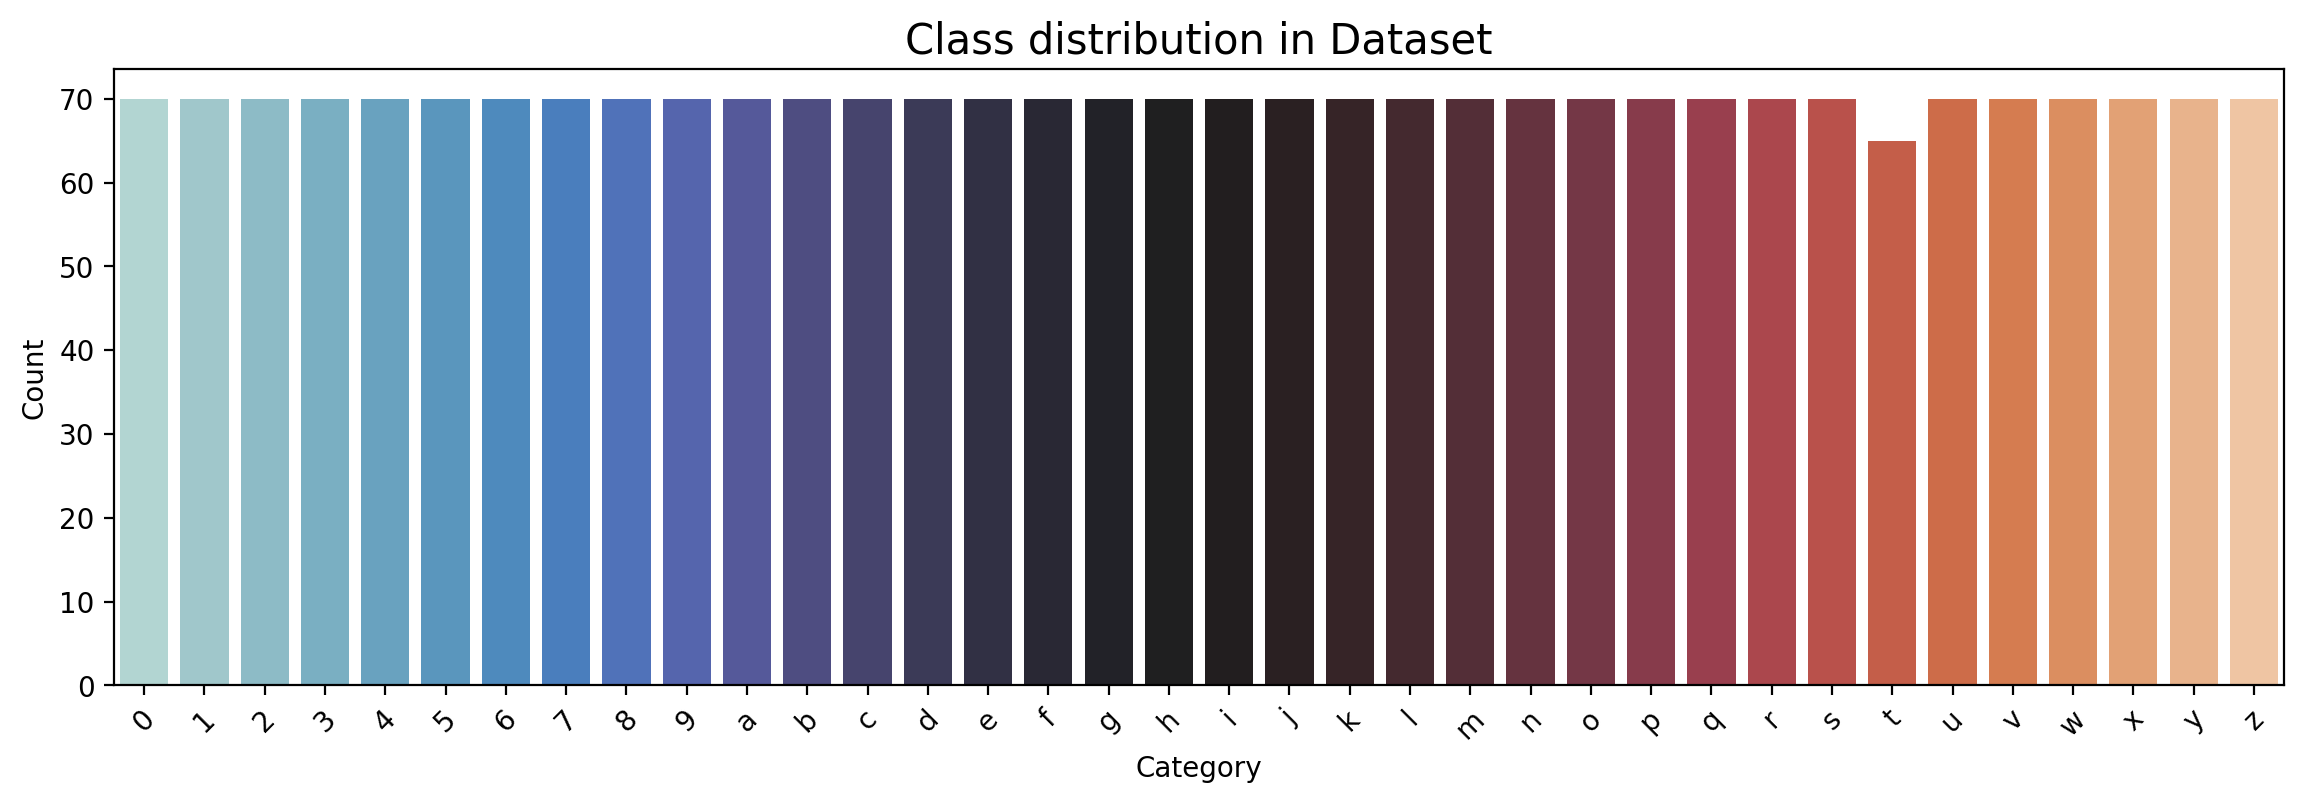

In [7]:
import seaborn as sns
import numpy as np

# Calculate unique category counts
label, count = np.unique(df['category'], return_counts=True)

# Create a DataFrame with counts
uni = pd.DataFrame(data={'Category': [categories[l] for l in label], 'Count': count})

# Plot the class distribution
plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(data=uni, x='Category', y='Count', palette='icefire').set_title(
    'Class distribution in Dataset', fontsize=15
)
plt.xticks(rotation=45)
plt.show()

In [8]:
pip install split-folders

In [9]:
import splitfolders

splitfolders.ratio('asl_dataset/asl_dataset',output='working', seed=1333, ratio=(0.8,0.1,0.1))

Copying files: 2515 files [00:00, 8408.96 files/s]


Copying files to folder so we can use them.

## Data Processing

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Hyperparameters
batch_size = 32
image_size = 200
img_channel = 3
n_classes = 36
epochs = 30
patience = 5
min_delta = 0.001
learning_rate = 0.001

# Dataset Transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Dataset and DataLoaders
train_dataset = datasets.ImageFolder('working/train', transform=transform)
val_dataset = datasets.ImageFolder('working/val', transform=transform)
test_dataset = datasets.ImageFolder('working/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Linear Model

In [26]:
class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleLinearModel, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc(x)
        return x


## Training Liner Model

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 10.91it/s]


Epoch 1: Train Loss: 5.6234, Train Accuracy: 0.6357


Epoch 1/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


Epoch 1: Validation Loss: 1.7367, Validation Accuracy: 0.8127
Validation loss improved (inf -> 1.7367). Saving model...


Epoch 2/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.63it/s]


Epoch 2: Train Loss: 1.2855, Train Accuracy: 0.8549


Epoch 2/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


Epoch 2: Validation Loss: 1.6040, Validation Accuracy: 0.8048
Validation loss improved (1.7367 -> 1.6040). Saving model...


Epoch 3/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.21it/s]


Epoch 3: Train Loss: 1.0264, Train Accuracy: 0.8991


Epoch 3/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


Epoch 3: Validation Loss: 1.2539, Validation Accuracy: 0.8406
Validation loss improved (1.6040 -> 1.2539). Saving model...


Epoch 4/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.68it/s]


Epoch 4: Train Loss: 0.6249, Train Accuracy: 0.9245


Epoch 4/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


Epoch 4: Validation Loss: 1.1291, Validation Accuracy: 0.8685
Validation loss improved (1.2539 -> 1.1291). Saving model...


Epoch 5/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.29it/s]


Epoch 5: Train Loss: 0.4693, Train Accuracy: 0.9538


Epoch 5/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


Epoch 5: Validation Loss: 1.3172, Validation Accuracy: 0.8725
No improvement in validation loss for 1/5 epochs.


Epoch 6/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.61it/s]


Epoch 6: Train Loss: 0.6128, Train Accuracy: 0.9468


Epoch 6/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 11.50it/s]


Epoch 6: Validation Loss: 0.6328, Validation Accuracy: 0.9283
Validation loss improved (1.1291 -> 0.6328). Saving model...


Epoch 7/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.24it/s]


Epoch 7: Train Loss: 0.3247, Train Accuracy: 0.9677


Epoch 7/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


Epoch 7: Validation Loss: 0.6894, Validation Accuracy: 0.9243
No improvement in validation loss for 1/5 epochs.


Epoch 8/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.65it/s]


Epoch 8: Train Loss: 0.2254, Train Accuracy: 0.9712


Epoch 8/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 11.98it/s]


Epoch 8: Validation Loss: 0.3752, Validation Accuracy: 0.9363
Validation loss improved (0.6328 -> 0.3752). Saving model...


Epoch 9/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.11it/s]


Epoch 9: Train Loss: 0.2337, Train Accuracy: 0.9692


Epoch 9/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


Epoch 9: Validation Loss: 1.0475, Validation Accuracy: 0.9163
No improvement in validation loss for 1/5 epochs.


Epoch 10/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.52it/s]


Epoch 10: Train Loss: 0.2902, Train Accuracy: 0.9682


Epoch 10/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 11.72it/s]


Epoch 10: Validation Loss: 0.8331, Validation Accuracy: 0.9004
No improvement in validation loss for 2/5 epochs.


Epoch 11/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.01it/s]


Epoch 11: Train Loss: 0.2754, Train Accuracy: 0.9697


Epoch 11/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


Epoch 11: Validation Loss: 0.5070, Validation Accuracy: 0.9363
No improvement in validation loss for 3/5 epochs.


Epoch 12/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.54it/s]


Epoch 12: Train Loss: 0.1310, Train Accuracy: 0.9841


Epoch 12/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 10.42it/s]


Epoch 12: Validation Loss: 0.4698, Validation Accuracy: 0.9522
No improvement in validation loss for 4/5 epochs.


Epoch 13/30 - Training: 100%|██████████| 63/63 [00:05<00:00, 11.44it/s]


Epoch 13: Train Loss: 0.0146, Train Accuracy: 0.9970


Epoch 13/30 - Validation: 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]
<ipython-input-27-22fd3d4275f0>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_di

Epoch 13: Validation Loss: 0.5288, Validation Accuracy: 0.9562
No improvement in validation loss for 5/5 epochs.
Restoring best weights.
Early stopping triggered.


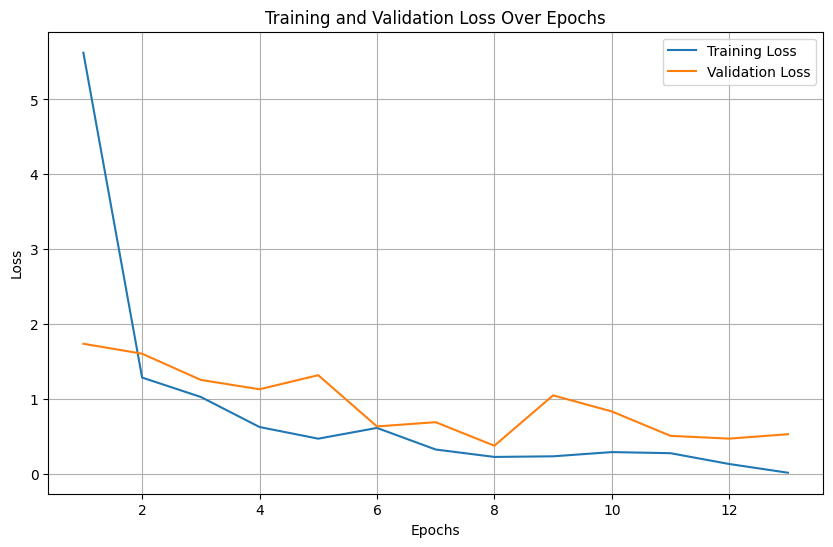

In [27]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.save_path = save_path
        self.best_val_loss = float('inf')
        self.counter = 0

    def __call__(self, model, val_loss):
        if val_loss < self.best_val_loss - self.min_delta:
            print(f"Validation loss improved ({self.best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
            self.best_val_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            print(f"No improvement in validation loss for {self.counter}/{self.patience} epochs.")

        if self.counter >= self.patience:
            if self.restore_best_weights:
                print("Restoring best weights.")
                model.load_state_dict(torch.load(self.save_path))
            return True
        return False

# Training Function
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, patience, min_delta):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Optimizer and Loss Function
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=1)

    # Initialize EarlyStopping
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta, save_path="best_model.pth")

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_accuracy = train_correct / train_total
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Adjust learning rate
        scheduler.step(val_loss)

        # Check early stopping
        if early_stopping(model, val_loss):
            print("Early stopping triggered.")
            break

    # Return loss values for plotting
    return train_losses, val_losses

# Define Model
input_size = img_channel * image_size * image_size
linear_model = SimpleLinearModel(input_size=input_size, num_classes=n_classes)

# Train the Model
train_losses, val_losses = train_model(
    model=linear_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=epochs,
    learning_rate=learning_rate,
    patience=patience,
    min_delta=min_delta,
)

# Plot Loss Curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


## Custom CNN

In [179]:


# Updated CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes=36):
        super(CNNModel, self).__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(img_channel, 32, kernel_size=3, padding=1),  # padding='same' -> padding=1
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=0),  # padding='same' -> padding=0
            nn.Dropout(0.2),
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=0),
            nn.Dropout(0.3),
        )

        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=0),
            nn.Dropout(0.3),
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (image_size // 8) * (image_size // 8), 512),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Dropout(0.25), # added
            nn.Linear(512, 128),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.fc(x)
        return x

## Training Custom CNN

Epoch 1/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  4.90it/s]


Train Loss: 2.6359, Train Accuracy: 0.2674


Epoch 1/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]


Validation Loss: 1.0614, Validation Accuracy: 0.7092
Validation loss improved (inf -> 1.0614). Saving model...


Epoch 2/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]


Train Loss: 0.6507, Train Accuracy: 0.7868


Epoch 2/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]


Validation Loss: 0.2871, Validation Accuracy: 0.9044
Validation loss improved (1.0614 -> 0.2871). Saving model...


Epoch 3/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]


Train Loss: 0.2753, Train Accuracy: 0.9021


Epoch 3/30 - Validation: 100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


Validation Loss: 0.1558, Validation Accuracy: 0.9363
Validation loss improved (0.2871 -> 0.1558). Saving model...


Epoch 4/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  4.92it/s]


Train Loss: 0.1707, Train Accuracy: 0.9359


Epoch 4/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]


Validation Loss: 0.1754, Validation Accuracy: 0.9402
No improvement in validation loss for 1/5 epochs.


Epoch 5/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


Train Loss: 0.1367, Train Accuracy: 0.9553


Epoch 5/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.82it/s]


Validation Loss: 0.2025, Validation Accuracy: 0.9323
No improvement in validation loss for 2/5 epochs.


Epoch 6/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


Train Loss: 0.1161, Train Accuracy: 0.9578


Epoch 6/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]


Validation Loss: 0.1707, Validation Accuracy: 0.9442
No improvement in validation loss for 3/5 epochs.


Epoch 7/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


Train Loss: 0.0876, Train Accuracy: 0.9717


Epoch 7/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]


Validation Loss: 0.1195, Validation Accuracy: 0.9602
Validation loss improved (0.1558 -> 0.1195). Saving model...


Epoch 8/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  5.05it/s]


Train Loss: 0.0620, Train Accuracy: 0.9791


Epoch 8/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Validation Loss: 0.1281, Validation Accuracy: 0.9562
No improvement in validation loss for 1/5 epochs.


Epoch 9/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]


Train Loss: 0.0697, Train Accuracy: 0.9811


Epoch 9/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]


Validation Loss: 0.1241, Validation Accuracy: 0.9721
No improvement in validation loss for 2/5 epochs.


Epoch 10/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


Train Loss: 0.0398, Train Accuracy: 0.9866


Epoch 10/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


Validation Loss: 0.1293, Validation Accuracy: 0.9641
No improvement in validation loss for 3/5 epochs.


Epoch 11/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


Train Loss: 0.0373, Train Accuracy: 0.9901


Epoch 11/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Validation Loss: 0.1628, Validation Accuracy: 0.9681
No improvement in validation loss for 4/5 epochs.


Epoch 12/30 - Training: 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


Train Loss: 0.0530, Train Accuracy: 0.9841


Epoch 12/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]
<ipython-input-180-7ca745831eac>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_d

Validation Loss: 0.1608, Validation Accuracy: 0.9681
No improvement in validation loss for 5/5 epochs.
Restoring best weights.
Early stopping triggered.


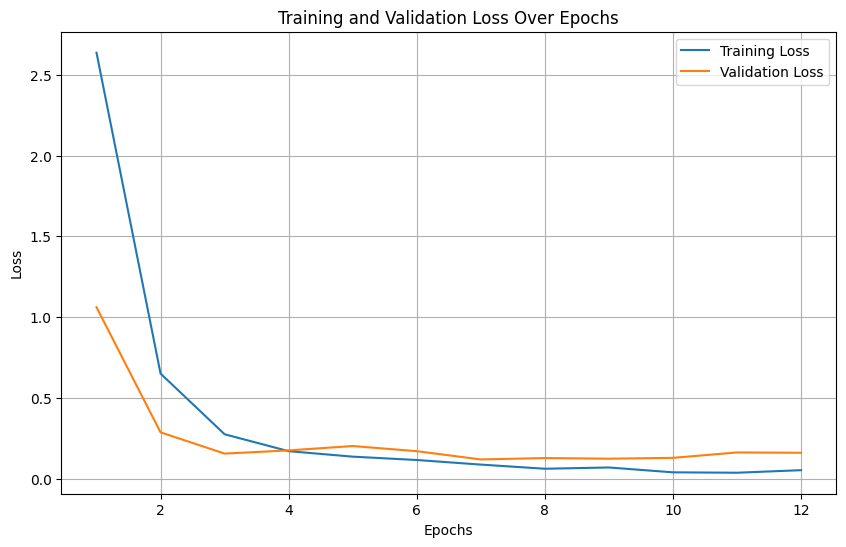

In [180]:

# Instantiate Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(num_classes=n_classes).to(device)

# Optimizer and Loss Function
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=1)

# Early Stopping
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True, save_path="best_linear_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.save_path = save_path
        self.best_val_loss = float('inf')
        self.counter = 0

    def __call__(self, model, val_loss):
        if val_loss < self.best_val_loss - self.min_delta:
            print(f"Validation loss improved ({self.best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
            self.best_val_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            print(f"No improvement in validation loss for {self.counter}/{self.patience} epochs.")

        if self.counter >= self.patience:
            if self.restore_best_weights:
                print("Restoring best weights.")
                model.load_state_dict(torch.load(self.save_path))
            return True
        return False

# Training Function
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Optimizer and Loss Function
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=1)

    # Initialize EarlyStopping
    early_stopping = EarlyStopping(patience=5, save_path="best_linear_model.pth")

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_accuracy = train_correct / train_total
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Adjust learning rate
        scheduler.step(val_loss)

        # Check early stopping
        if early_stopping(model, val_loss):
            print("Early stopping triggered.")
            break

    # Return loss values for plotting
    return train_losses, val_losses

# Instantiate EarlyStopping
early_stopping = EarlyStopping(
    patience=patience,
    min_delta=min_delta,
    save_path="best_model.pth"
)

# Train Model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=epochs)

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()



## ResNet (sophisticated model) and Training

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]
Epoch 1/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.09it/s]


Train Loss: 0.6486, Train Accuracy: 0.8320


Epoch 1/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.28it/s]


Validation Loss: 0.3819, Validation Accuracy: 0.8645
Validation loss improved (inf -> 0.3819). Saving model...


Epoch 2/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.14it/s]


Train Loss: 0.1582, Train Accuracy: 0.9463


Epoch 2/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.47it/s]


Validation Loss: 0.2402, Validation Accuracy: 0.9203
Validation loss improved (0.3819 -> 0.2402). Saving model...


Epoch 3/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.12it/s]


Train Loss: 0.0970, Train Accuracy: 0.9717


Epoch 3/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.78it/s]


Validation Loss: 0.1740, Validation Accuracy: 0.9402
Validation loss improved (0.2402 -> 0.1740). Saving model...


Epoch 4/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.12it/s]


Train Loss: 0.0788, Train Accuracy: 0.9771


Epoch 4/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.56it/s]


Validation Loss: 0.9875, Validation Accuracy: 0.7570
No improvement in validation loss for 1/5 epochs.


Epoch 5/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.11it/s]


Train Loss: 0.0653, Train Accuracy: 0.9806


Epoch 5/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.90it/s]


Validation Loss: 0.1884, Validation Accuracy: 0.9363
No improvement in validation loss for 2/5 epochs.


Epoch 6/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.18it/s]


Train Loss: 0.0740, Train Accuracy: 0.9776


Epoch 6/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.50it/s]


Validation Loss: 0.2917, Validation Accuracy: 0.9124
No improvement in validation loss for 3/5 epochs.


Epoch 7/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.20it/s]


Train Loss: 0.0244, Train Accuracy: 0.9925


Epoch 7/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.60it/s]


Validation Loss: 0.0253, Validation Accuracy: 0.9880
Validation loss improved (0.1740 -> 0.0253). Saving model...


Epoch 8/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.14it/s]


Train Loss: 0.0042, Train Accuracy: 0.9995


Epoch 8/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.53it/s]


Validation Loss: 0.0199, Validation Accuracy: 0.9920
Validation loss improved (0.0253 -> 0.0199). Saving model...


Epoch 9/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.11it/s]


Train Loss: 0.0014, Train Accuracy: 1.0000


Epoch 9/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.38it/s]


Validation Loss: 0.0194, Validation Accuracy: 0.9920
No improvement in validation loss for 1/5 epochs.


Epoch 10/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.15it/s]


Train Loss: 0.0011, Train Accuracy: 1.0000


Epoch 10/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.34it/s]


Validation Loss: 0.0158, Validation Accuracy: 0.9920
Validation loss improved (0.0199 -> 0.0158). Saving model...


Epoch 11/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.11it/s]


Train Loss: 0.0009, Train Accuracy: 1.0000


Epoch 11/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.19it/s]


Validation Loss: 0.0180, Validation Accuracy: 0.9920
No improvement in validation loss for 1/5 epochs.


Epoch 12/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.12it/s]


Train Loss: 0.0008, Train Accuracy: 1.0000


Epoch 12/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.56it/s]


Validation Loss: 0.0139, Validation Accuracy: 0.9960
Validation loss improved (0.0158 -> 0.0139). Saving model...


Epoch 13/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.13it/s]


Train Loss: 0.0006, Train Accuracy: 1.0000


Epoch 13/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.51it/s]


Validation Loss: 0.0127, Validation Accuracy: 0.9960
Validation loss improved (0.0139 -> 0.0127). Saving model...


Epoch 14/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.07it/s]


Train Loss: 0.0006, Train Accuracy: 1.0000


Epoch 14/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.60it/s]


Validation Loss: 0.0141, Validation Accuracy: 0.9960
No improvement in validation loss for 1/5 epochs.


Epoch 15/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.10it/s]


Train Loss: 0.0006, Train Accuracy: 1.0000


Epoch 15/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.71it/s]


Validation Loss: 0.0138, Validation Accuracy: 0.9960
No improvement in validation loss for 2/5 epochs.


Epoch 16/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.16it/s]


Train Loss: 0.0005, Train Accuracy: 1.0000


Epoch 16/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.61it/s]


Validation Loss: 0.0131, Validation Accuracy: 0.9960
No improvement in validation loss for 3/5 epochs.


Epoch 17/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.15it/s]


Train Loss: 0.0005, Train Accuracy: 1.0000


Epoch 17/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.35it/s]


Validation Loss: 0.0140, Validation Accuracy: 0.9920
No improvement in validation loss for 4/5 epochs.


Epoch 18/30 - Training: 100%|██████████| 63/63 [00:10<00:00,  6.15it/s]


Train Loss: 0.0005, Train Accuracy: 1.0000


Epoch 18/30 - Validation: 100%|██████████| 8/8 [00:00<00:00,  9.19it/s]
<ipython-input-32-970051d594f1>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_di

Validation Loss: 0.0138, Validation Accuracy: 0.9960
No improvement in validation loss for 5/5 epochs.
Restoring best weights.
Early stopping triggered.


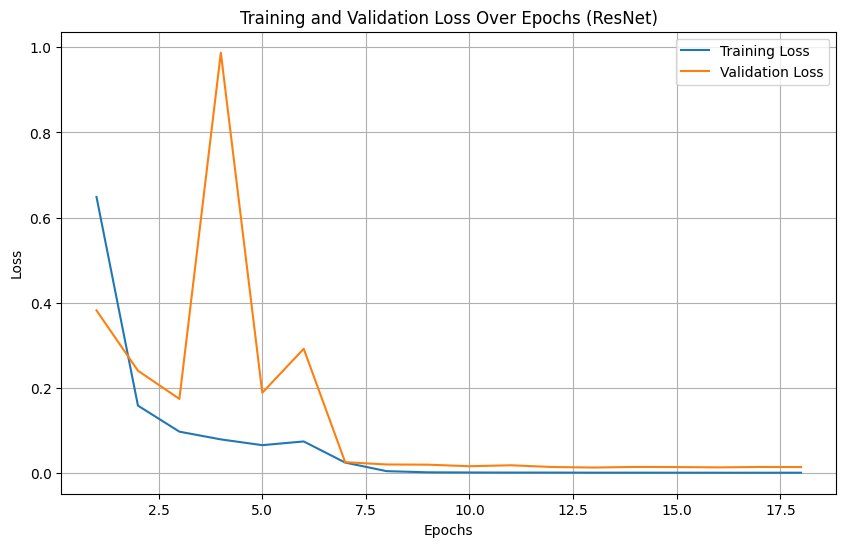

In [32]:
import torchvision.models as models
import torch.nn as nn

class ResNetBaseline(nn.Module):
    def __init__(self, num_classes=36, pretrained=True):
        super(ResNetBaseline, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)

        # Modify the fully connected layer to match the number of classes
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


# Instantiate ResNet Baseline
baseline_model = ResNetBaseline(num_classes=n_classes, pretrained=True).to(device)

# Optimizer, Loss, and Scheduler
baseline_optimizer = Adam(baseline_model.parameters(), lr=learning_rate)
baseline_criterion = nn.CrossEntropyLoss()
baseline_scheduler = ReduceLROnPlateau(baseline_optimizer, mode='max', factor=0.5, patience=2, verbose=1)

# EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True, save_path="best_model.pth"):
        """
        Initialize EarlyStopping.

        Args:
            patience (int): Number of epochs with no improvement before stopping.
            min_delta (float): Minimum change to qualify as improvement.
            restore_best_weights (bool): Restore the model with the best weights.
            save_path (str): File path to save the best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.save_path = save_path
        self.best_val_loss = float('inf')
        self.counter = 0

    def __call__(self, model, val_loss):
        if val_loss < self.best_val_loss - self.min_delta:
            print(f"Validation loss improved ({self.best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
            self.best_val_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)  # Save model weights
        else:
            self.counter += 1
            print(f"No improvement in validation loss for {self.counter}/{self.patience} epochs.")

        if self.counter >= self.patience:
            if self.restore_best_weights:
                print("Restoring best weights.")
                model.load_state_dict(torch.load(self.save_path))
            return True
        return False


# Training Function for ResNet with EarlyStopping and LR Scheduler
def train_resnet_model(model, train_loader, val_loader, num_epochs=30):
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path="best_model.pth")

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            baseline_optimizer.zero_grad()
            outputs = model(inputs)
            loss = baseline_criterion(outputs, targets)
            loss.backward()
            baseline_optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_accuracy = train_correct / train_total
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = baseline_criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Step the scheduler
        baseline_scheduler.step(val_accuracy)

        # Check EarlyStopping
        if early_stopping(model, val_loss):
            print("Early stopping triggered.")
            break

    # Return the loss values for plotting
    return train_losses, val_losses

# Train ResNet Model
resnet_train_losses, resnet_val_losses = train_resnet_model(baseline_model, train_loader, val_loader, num_epochs=epochs)

# Plot Losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(resnet_train_losses) + 1), resnet_train_losses, label="Training Loss")
plt.plot(range(1, len(resnet_val_losses) + 1), resnet_val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs (ResNet)")
plt.legend()
plt.grid()
plt.show()


# Model Evaluation

In [28]:
def evaluate_model(model, val_loader, criterion, device):
    model.to(device)  # Send model to device
    model.eval()  # Set model to evaluation mode

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return average_loss, accuracy

## Linear Model Evaluation

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
average_loss, accuracy = evaluate_model(linear_model, val_loader, criterion, device)

print(f"Validation Loss: {average_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")

average_loss, accuracy = evaluate_model(linear_model, test_loader, criterion, device)

print(f"Test Loss: {average_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

average_loss, accuracy = evaluate_model(linear_model, train_loader, criterion, device)

print(f"Train Loss: {average_loss:.4f}")
print(f"Train Accuracy: {accuracy:.2f}%")

Validation Loss: 0.3752
Validation Accuracy: 93.63%
Test Loss: 1.1510
Test Accuracy: 88.49%
Train Loss: 0.1837
Train Accuracy: 97.37%


## Custom CNN Evaluation

Saved best model to "best_model_balanced.pth"

In [184]:
# Instantiate the model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = CNNModel(num_classes=n_classes).to(device)

# Load the best weights
model.load_state_dict(torch.load("best_model_balanced.pth"))

# Set the model to evaluation mode
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
average_loss, accuracy = evaluate_model(model, val_loader, criterion, device)

print(f"Validation Loss: {average_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
average_loss, accuracy = evaluate_model(model, test_loader, criterion, device)

print(f"Test Loss: {average_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
average_loss, accuracy = evaluate_model(model, train_loader, criterion, device)

print(f"Train Loss: {average_loss:.4f}")
print(f"Train Accuracy: {accuracy:.2f}%")


<ipython-input-184-f2dde1fdaed8>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_balanced.pth"))


CNNModel(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=

## ResNet Evaluation

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
average_loss, accuracy = evaluate_model(baseline_model, val_loader, criterion, device)

print(f"Validation Loss: {average_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
average_loss, accuracy = evaluate_model(baseline_model, test_loader, criterion, device)

print(f"Test Loss: {average_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
average_loss, accuracy = evaluate_model(baseline_model, train_loader, criterion, device)

print(f"Train Loss: {average_loss:.4f}")
print(f"Train Accuracy: {accuracy:.2f}%")

Validation Loss: 0.0127
Validation Accuracy: 99.60%
Test Loss: 0.0651
Test Accuracy: 98.02%
Train Loss: 0.0002
Train Accuracy: 100.00%


In [188]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Example image paths from test dataset
image_paths = ["working/test/4/hand1_4_dif_seg_5_cropped.jpeg", "working/test/5/hand1_5_dif_seg_5_cropped.jpeg"]  # Replace with your paths
labels = ["4", "5"]  # Corresponding labels for reference


Let's see a few of the images predicted and their actual labels.

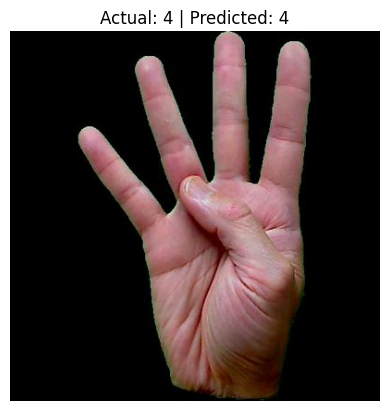

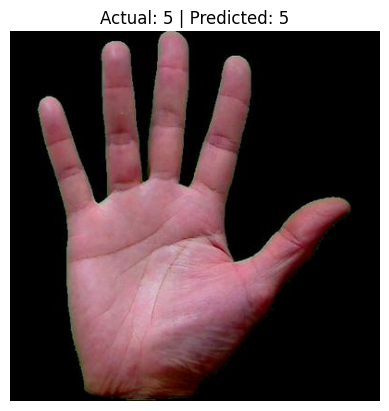

In [189]:
# Define a mapping from class indices to labels
class_labels = train_dataset.classes  # `ImageFolder` provides class names in sorted order

for i, image_path in enumerate(image_paths):
    image_tensor = preprocess_image(image_path).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class = outputs.max(1)  # Get index of highest score
        predicted_label = class_labels[predicted_class.item()]

    # Display the image and predictions
    plt.imshow(Image.open(image_path))
    plt.title(f"Actual: {labels[i]} | Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()


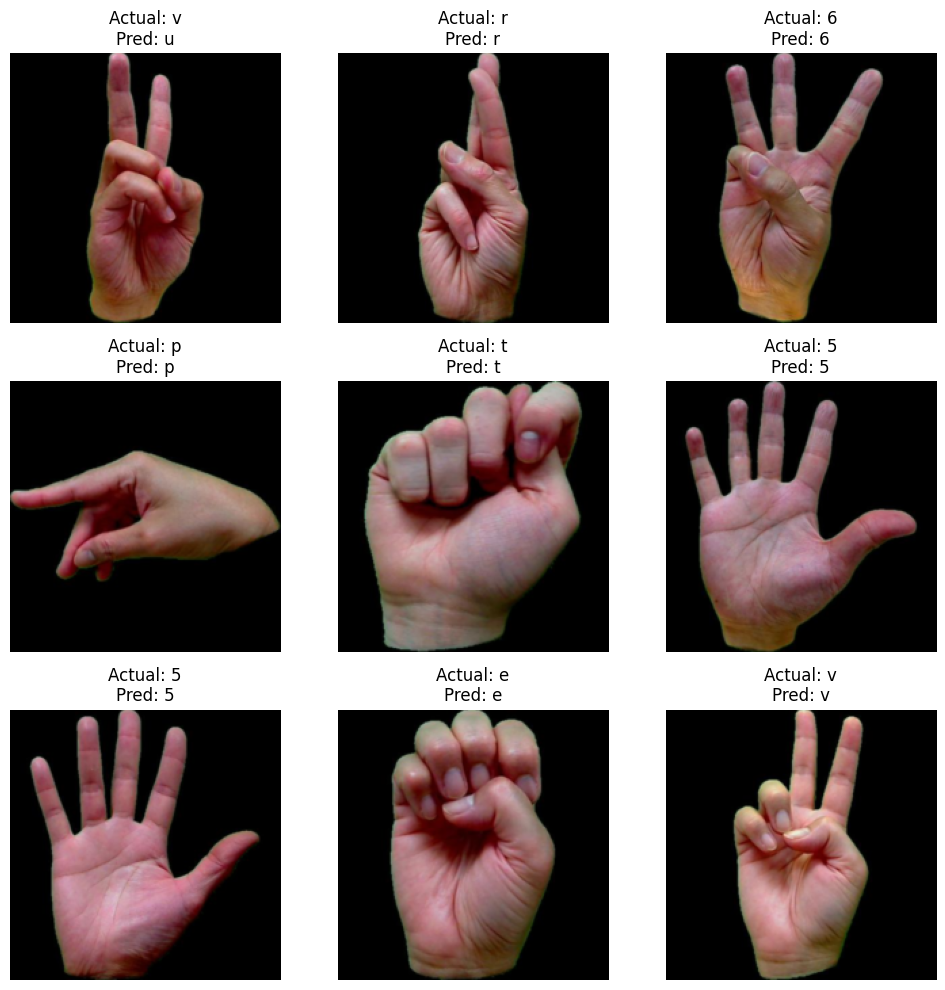

In [190]:
import random

# Collect all images and labels from the test_loader
test_images = []
test_labels = []

for inputs, targets in test_loader:
    for img, lbl in zip(inputs, targets):
        test_images.append(img)
        test_labels.append(lbl)

# Randomize the order of images and labels
data = list(zip(test_images, test_labels))
random.shuffle(data)
test_images, test_labels = zip(*data)

# Display 9 random images
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
model.eval()

for image_count in range(9):
    ax = axs[image_count // 3, image_count % 3]
    img = test_images[image_count]
    lbl = test_labels[image_count]

    img_tensor = img.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = output.max(1)

    # Display the image with prediction and label
    ax.imshow(img.permute(1, 2, 0).cpu().numpy())  # Convert to HWC format
    ax.set_title(f"Actual: {class_labels[lbl.item()]}\nPred: {class_labels[predicted.item()]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


Now let's build a confusion matrix to see how the modle performs

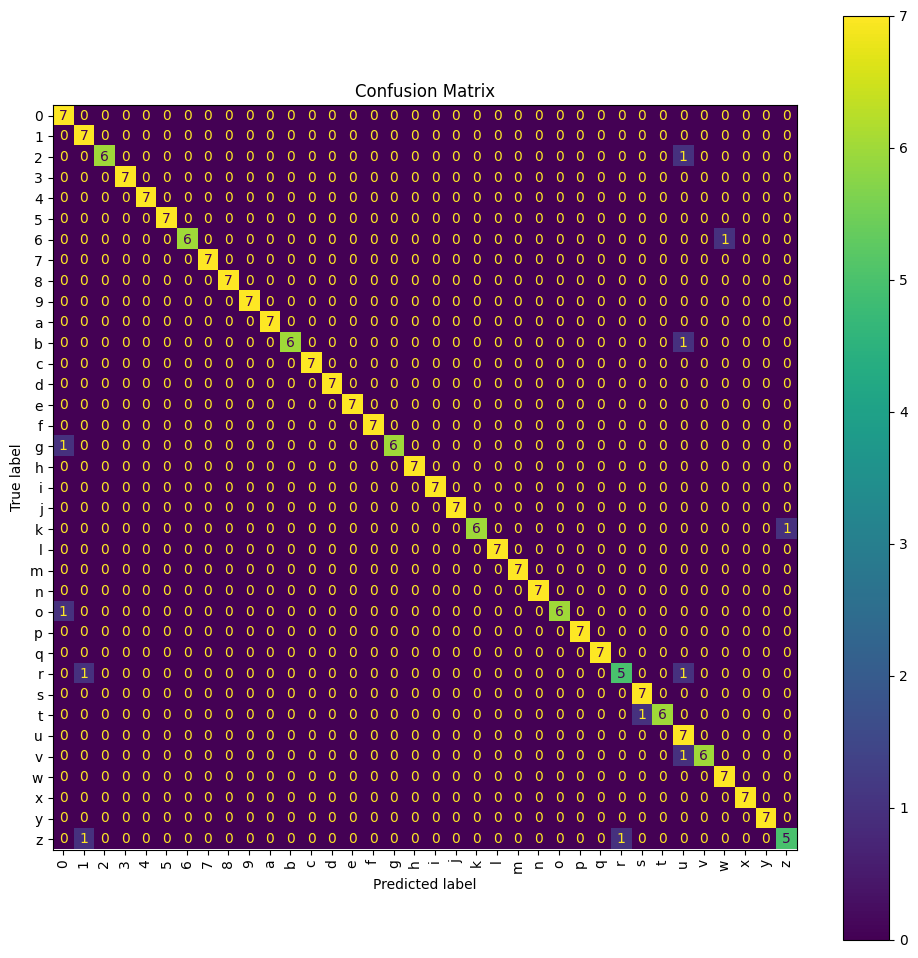

In [124]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect all true labels and predictions
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(n_classes))

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust size as needed
disp.plot(cmap="viridis", ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [126]:
report = classification_report(true_labels, predicted_labels, target_names=class_labels, zero_division=0)

# Print the classification report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.78      1.00      0.88         7
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      0.86      0.92         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
           a       1.00      1.00      1.00         7
           b       1.00      0.86      0.92         7
           c       1.00      1.00      1.00         7
           d       1.00      1.00      1.00         7
           e       1.00      1.00      1.00         7
           f       1.00      1.00      1.00         7
           g       1.00      0.86      0.92         7
   

In [169]:
from sklearn.metrics import classification_report
import torch

# Function to calculate correct and false predictions for each class
def get_correct_and_false_predictions(model, data_loader, device, num_classes):
    correct_predictions = [0] * num_classes
    false_predictions = [0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(targets.size(0)):
                if predicted[i] == targets[i]:
                    correct_predictions[targets[i]] += 1
                else:
                    false_predictions[targets[i]] += 1

    return correct_predictions, false_predictions

correct_predictions, false_predictions = get_correct_and_false_predictions(model, val_loader, device, num_classes=n_classes)

# Print the number of correct and false predictions per class
print("Correct and False Predictions per Class:")
for i in range(n_classes):
    print(f"Class {i} - Correct: {correct_predictions[i]}, False: {false_predictions[i]}")

# Print the classification report
true_labels = []
predicted_labels = []
for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    true_labels.extend(targets.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels, zero_division=0)
print("\nClassification Report:\n")
print(report)


Correct and False Predictions per Class:
Class 0 - Correct: 7, False: 0
Class 1 - Correct: 7, False: 0
Class 2 - Correct: 7, False: 0
Class 3 - Correct: 7, False: 0
Class 4 - Correct: 7, False: 0
Class 5 - Correct: 7, False: 0
Class 6 - Correct: 6, False: 1
Class 7 - Correct: 7, False: 0
Class 8 - Correct: 7, False: 0
Class 9 - Correct: 7, False: 0
Class 10 - Correct: 7, False: 0
Class 11 - Correct: 7, False: 0
Class 12 - Correct: 7, False: 0
Class 13 - Correct: 7, False: 0
Class 14 - Correct: 7, False: 0
Class 15 - Correct: 7, False: 0
Class 16 - Correct: 7, False: 0
Class 17 - Correct: 7, False: 0
Class 18 - Correct: 7, False: 0
Class 19 - Correct: 7, False: 0
Class 20 - Correct: 7, False: 0
Class 21 - Correct: 7, False: 0
Class 22 - Correct: 7, False: 0
Class 23 - Correct: 6, False: 1
Class 24 - Correct: 5, False: 2
Class 25 - Correct: 7, False: 0
Class 26 - Correct: 7, False: 0
Class 27 - Correct: 7, False: 0
Class 28 - Correct: 7, False: 0
Class 29 - Correct: 6, False: 0
Class 30 